In [1]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph,START,END
from langgraph.checkpoint.memory import InMemorySaver
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter


import fitz
from io import BytesIO
import base64
  
import torch
from transformers import CLIPProcessor, CLIPModel
from langchain.schema import Document

from PIL import Image
from dotenv import load_dotenv
load_dotenv()

True

In [26]:
from transformers import CLIPProcessor, CLIPModel, BlipProcessor, BlipForConditionalGeneration

# Load CLIP for embeddings
clip_model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

# Load BLIP for captioning
caption_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
caption_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model.to(device)
caption_model.to(device)

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [28]:
# ===== Caption Function =====
def caption_image(pil_image):
    inputs = caption_processor(pil_image, return_tensors="pt")
    out = caption_model.generate(**inputs, max_length=20)
    return caption_processor.decode(out[0], skip_special_tokens=True)

# STEP 1 — Text and Image Embedding Function

In [29]:
def embedd_image(image_data):
    if isinstance(image_data,str):
        image = Image.open(image_data).convert("RGB")
    else:
        image = image_data
    inputs = clip_processor(images=image,return_tensors="pt").to(device)
    with torch.no_grad():#normalizing
        features = clip_model.get_image_features(**inputs)
        features = features/features.norm(dim=1,keepdim=True)
        return features.squeeze().numpy()

def embedd_text(text):
    inputs = clip_processor(text=text,return_tensors="pt",truncation=True,max_length=77).to(device)
    with torch.no_grad():
        features = clip_model.get_text_features(**inputs)
        features = features/features.norm(dim=1,keepdim=True)
        return features.squeeze().numpy()   
    


# STEP 2 — Extract Text and Image and Store them in a List

In [30]:
def extract_text_and_image(pdf):
    doc = fitz.open(pdf)
    data = []

    for i, page in enumerate(doc):
        # Extract text
        text = page.get_text()
        if text.strip():
            data.append({
                "type": "text",
                "page": i,
                "content": text
            })

        # Extract images for this page
        images = page.get_images(full=True)
        for img_index, img in enumerate(images):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            img_b64 = base64.b64encode(image_bytes).decode("utf-8")

            # Load image
            pil_image = Image.open(BytesIO(image_bytes)).convert("RGB")

            # Generate caption
            caption = caption_image(pil_image)

            # Assign unique ID
            image_id = f"page{i}_img{img_index}"

            data.append({
                "type": "image",
                "page": i,
                "content": caption,  # Caption for LLM
                "b64": img_b64,      # Base64 for display
                "image_id": image_id
            })

    doc.close()
    return data


# STEP 3 — Convert to LangChain Documents

In [31]:
def convert_to_document(data):
    docs = []
    for item in data:
        if item["type"]=="text":
            docs.append(Document(page_content=item["content"],metadata={"type":"text",
                                                                        "page":item["page"]}))
        else:
            docs.append(Document(page_content=item["content"],metadata={"type":"image",
                                                                        "page":item["page"],
                                                                        "image_id": item["image_id"],
                                                                        "b64": item["b64"]
                                                                        }))
    return docs


# STEP 4 — Create multimodal embeddings

In [32]:
from tqdm import tqdm
class CreateMultimodalEmbedding:
    def __init__(self):
        pass

    def embedd_document(self,docs):
        embedding = []
        for doc in tqdm(docs, desc="Embedding documents"):
            if doc.metadata["type"]=="text":
                emb = embedd_text(doc.page_content)
            else:
                image_data = base64.b64decode(doc.metadata["b64"])
                image = Image.open(BytesIO(image_data)).convert("RGB")
                emb =embedd_image(image)
            embedding.append(emb)
        return embedding

    def embedd_query(self,query):
        if isinstance(query,str):
            return embedd_text(query)
        elif isinstance(query,Image.Image):
            return embedd_image(query)
        else:
            raise ValueError("Unsupported query type for embedding")
    
    def __call__(self, text:str):
        return self.embedd_query(text)

# STEP 5 — Create Vector Store

In [33]:
import os
os.makedirs("../FAISS",exist_ok=True)
path_vector_store = "../FAISS"

def create_vector_store(docs,path=path_vector_store):
    embedder = CreateMultimodalEmbedding()
    embedding = embedder.embedd_document(docs=docs)

    # All vectors now same dimension from CLIP
    text_embedding = [(doc.page_content,emb) for doc,emb in zip(docs,embedding)]

    vector_store = FAISS.from_embeddings(
        text_embeddings=text_embedding,
        embedding=embedder,
        metadatas=[doc.metadata for doc in docs]
    )
    vector_store.save_local(path)
    return vector_store,embedder

# STEP 6 — RetrievalQA Pipeline

In [34]:
template = """
You are a helpful medical assistant. You are given the following context extracted from documents, which may include text passages and image captions from medical documents.

Context:
{context}

Question:
{question}

Instructions:
- The context may include image captions that describe medical images
- If the question is about an uploaded image, use the image captions to explain what the image shows
- Provide detailed medical explanations based on the context
- Be specific about medical conditions, symptoms, and treatments mentioned

Please provide a clear and detailed explanation based on the context.
"""

In [42]:
from langchain_core.runnables import RunnableLambda
from langchain_groq import ChatGroq
from PIL import Image

def custom_rag_pipeline(vector_store, embedder):
    retriever = vector_store.as_retriever()
    llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

    def pipeline_step(query):
        # If query is an image, embed it and retrieve docs by similarity
        if isinstance(query, Image.Image):
            query_embedding = embedder.embedd_query(query)
            docs = vector_store.similarity_search_by_vector(query_embedding, k=5)
            question = "Explain this image base on the context."
        else:
            # Otherwise treat as text query
            docs = retriever.get_relevant_documents(query)
            question = query

        cleaned = []
        for doc in docs:
            if doc.metadata.get("type") == "image":
                img_id = doc.metadata.get("image_id", "unknown")
                page = doc.metadata.get("page", "unknown")
                # Include the actual caption content
                cleaned.append(f"Image {img_id} (Page {page}): {doc.page_content}")
            else:
                cleaned.append(doc.page_content)
        
        context = "\n\n".join(cleaned)
        llm_answer = llm.invoke(template.format(context=context, question=question))
        
        return {
            "answer": llm_answer.content if hasattr(llm_answer, "content") else str(llm_answer),
            "source_documents": docs
        }

    return RunnableLambda(pipeline_step)


In [37]:
pdf_path = "Oxford-Handbook-of-Medical-Dermatology.pdf"
extract_data = extract_text_and_image(pdf=pdf_path)  #STEP 1: Extract Text and Images
docs = convert_to_document(extract_data) #STEP 2: Convert to langchain document
vector_store,embedder = create_vector_store(docs=docs) #STEP 3: Create vector store 
model = custom_rag_pipeline(vector_store,embedder) #STEP 4: Create RAG pipeline

Embedding documents: 100%|██████████| 841/841 [02:02<00:00,  6.85it/s]
`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


# Load Vector Store From Local

In [24]:
embedder = CreateMultimodalEmbedding()
vector_store  = FAISS.load_local(folder_path="../FAISS",embeddings=embedder,allow_dangerous_deserialization=True)
model = custom_rag_pipeline(vector_store,embedder=embedder) #STEP 4: Create RAG pipeline

`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


# Image Query

Answer: Based on the provided context, I will attempt to explain the images.

It appears that there are several medical images described in the context. I'll go through each image and provide a detailed explanation based on the captions.

1. **Image page174_img0 (Page174)**: The image shows a woman with "ac acu". This likely refers to a medical condition or symptom, but the abbreviation is unclear. However, based on the similarity with other image captions, it might be related to "acne" or another skin condition.

2. **Image page418_img1 (Page418)**: This image depicts a woman with "acuus" on her face. The term "acuus" seems to be a typo or an abbreviation. Given the context of other images, it's possible that it refers to "acne" or a similar skin condition. Acne is a common skin condition characterized by inflamed or infected sebaceous glands, typically occurring on the face.

3. **Image page423_img0 (Page423)**: The image shows a woman with "ac acus". Similar to the previous images, 

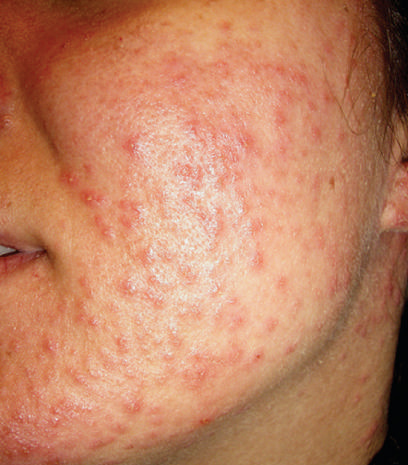

Page 418 IMAGE:


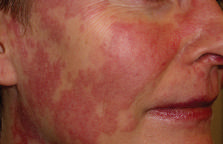

Page 423 IMAGE:


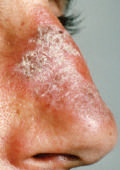

Page 488 IMAGE:


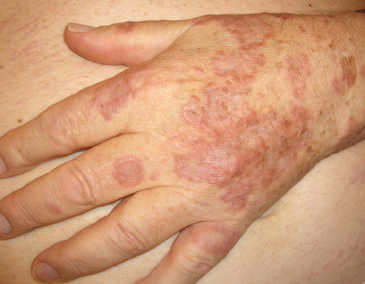

Page 172 IMAGE:


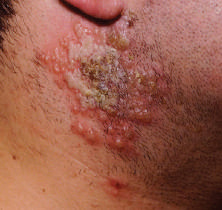

In [43]:
from IPython.display import Image as IPImage, display

image_query = Image.open("acne.jpg").convert("RGB")
result = model.invoke(image_query)  # now returns dict

print("Answer:", result["answer"])
print("\n--- Retrieved Documents ---\n")

for doc in result["source_documents"]:
    if doc.metadata["type"] == "text":
        print(f"Page {doc.metadata['page']} TEXT:\n{doc.page_content}\n")
    elif doc.metadata["type"] == "image":
        print(f"Page {doc.metadata['page']} IMAGE:")
        img_data = base64.b64decode(doc.metadata["b64"])
        display(IPImage(data=img_data))


In [41]:
from IPython.display import Image as IPImage, display

query = "what is acne"
result = model.invoke(query)  # now returns dict

print("Answer:", result["answer"])
print("\n--- Retrieved Documents ---\n")

for doc in result["source_documents"]:
    if doc.metadata["type"] == "text":
        print(f"Page {doc.metadata['page']} TEXT:\n{doc.page_content}\n")
    elif doc.metadata["type"] == "image":
        print(f"Page {doc.metadata['page']} IMAGE:")
        img_data = base64.b64decode(doc.metadata["b64"])
        display(IPImage(data=img_data))


C:\Users\hasee\AppData\Local\Temp\ipykernel_14664\1338609121.py:17: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(query)


Answer: Based on the context provided, I couldn't find a direct mention of acne. However, I can provide a general explanation of acne and its relation to skin conditions.

Acne is a common skin condition characterized by the occurrence of pimples, blackheads, and whiteheads on the face, chest, and back. It is often associated with hormonal changes, stress, and genetics. Acne can range from mild to severe and may require various treatments, including topical creams, oral antibiotics, and retinoids.

Although acne is not explicitly mentioned in the context, I notice that "Contact dermatitis" and "Adult-onset Still disease" are listed, which are both skin-related conditions. Contact dermatitis is a type of skin inflammation caused by exposure to allergens or irritants, while Adult-onset Still disease is a rare inflammatory disorder that can affect multiple parts of the body, including the skin.

The context also mentions "DIFFERENTIATION & THE SKIN BARRIER," which suggests that the topic 

# Using RetrievalQA Pipeline

In [16]:
from langchain.chains import RetrievalQA
def build_rag_pipeline(vectorstore):
    retriever = vectorstore.as_retriever()
    #llm = ChatOpenAI(model="gpt-4o", temperature=0)  # or "gpt-4o-mini" for cheaper
    llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")
    qa = RetrievalQA.from_chain_type(
        llm=llm,
        retriever=retriever,
        return_source_documents=True
    )
    return qa

In [ ]:
from IPython.display import Image as IPImage, display
pdf_path = "multimodal_sample.pdf"
extract_data = extract_text_and_image(pdf=pdf_path)  #STEP 1: Extract Text and Images
docs = convert_to_document(extract_data) #STEP 2: Convert to langchain document
vector_store,embedder = create_vector_store(docs=docs) #STEP 3: Create vector store 
qa = build_rag_pipeline(vector_store) #STEP 5: Create RAG pipeline

Embedding documents: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]
`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


Answer: The document mentions a chart, specifically a bar chart with red, green, and blue colors, but I'm a text-based AI and do not have the capability to display images. I can try to describe it based on the text:

The bar chart likely shows the revenue trends across Q1, Q2, and Q3. The chart probably has three bars, one for each quarter. 

- The bar for Q1 is likely moderate in height, indicating a moderate increase in revenue.
- The bar for Q2 is probably higher than Q1, indicating that Q2 outperformed Q1 due to marketing campaigns.
- The bar for Q3 is likely the tallest, indicating exponential growth due to global expansion.

The colors used are red, green, and blue, but without more information, I don't know which quarter corresponds to which color.

--- Retrieved Documents ---

[Page 0] TEXT:
Annual Revenue Overview
This document summarizes the revenue trends across Q1, Q2, and Q3. As illustrated in the chart
below, revenue grew steadily with the highest growth recorded in Q3.
Q

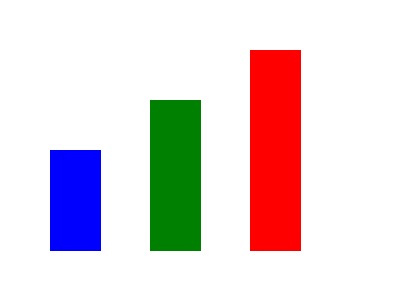

In [ ]:
query = "Sshow the image in document and explain it"
result = qa.invoke({"query": query})

print("Answer:", result["result"])
print("\n--- Retrieved Documents ---\n")

for doc in result["source_documents"]:
    if doc.metadata["type"] == "text":
        print(f"[Page {doc.metadata['page']}] TEXT:\n{doc.page_content}\n")
    elif doc.metadata["type"] == "image":
        print(f"[Page {doc.metadata['page']}] IMAGE:")
        img_data = base64.b64decode(doc.metadata["b64"])
        display(IPImage(data=img_data))